# Deep Learning 2024 - project 3
Grzegorz Zakrzewski, 313555

In [1]:
# tensorflow==2.10.1
# numpy==1.26.4
# matplotlib==3.8.3
# scikit-learn==1.4.2
# tensorflow-addons==0.22.0

import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")
np.random.seed(0)
keras.utils.set_random_seed(0)

c:\Users\grzegorzzakrzewski\Documents\deeplearing\env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\grzegorzzakrzewski\Documents\deeplearing\env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounte

In [2]:
# constants
plot_diffusion_steps = 50

min_signal_rate = 0.02
max_signal_rate = 0.95

embedding_dims = 32
embedding_max_frequency = 1000.0

batch_size = 32
ema = 0.999

In [3]:
path = "data0/lsun/bedroom"

DS = keras.preprocessing.image_dataset_from_directory(
    path,
    labels=None,
    batch_size=None,
    shuffle=False,
    seed=0,
    image_size=(256, 256),
    validation_split=None,
)

Found 303125 files belonging to 1 classes.


In [4]:
def preprocess_image(img, image_size):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size=[image_size, image_size], antialias=True)
    img = img / 255.0
    img = tf.clip_by_value(img, 0, 1)
    return img

In [5]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    log_min_freq = tf.math.log(embedding_min_frequency)
    log_max_freq = tf.math.log(embedding_max_frequency)
    frequencies = tf.exp(tf.linspace(log_min_freq, log_max_freq, embedding_dims // 2))
    angular_speeds = tf.cast(2.0 * math.pi * frequencies, dtype=tf.float32)
    sin_embeddings = tf.sin(angular_speeds * x)
    cos_embeddings = tf.cos(angular_speeds * x)
    embeddings = tf.concat([sin_embeddings, cos_embeddings], axis=-1)
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = get_network(image_size, widths, block_depth)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.cast(tf.acos(max_signal_rate), dtype=tf.float32)
        end_angle = tf.cast(tf.acos(min_signal_rate), dtype=tf.float32)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, model_i, num_rows=1, num_cols=5, diffusion_steps=plot_diffusion_steps):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.savefig(f"ddim_{model_i}.png", bbox_inches="tight", dpi=100)
        plt.show()

### FID

In [18]:
# https://stackoverflow.com/questions/70719562/calculating-fid-scores-for-gan-models-between-two-different-image-directory
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input


def calculate_fid(model, image_size, train_dataset, batch_size):
    dataset_cardinality = train_dataset.cardinality().numpy()
    batch_number = min(dataset_cardinality, 200)
    
    real_images = np.concatenate([i.numpy() for i in train_dataset.take(batch_number)])
    generated_images = np.concatenate([model.generate(num_images=batch_size, diffusion_steps=30).numpy() for _ in range(batch_number)])

    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    inception_model = InceptionV3(include_top=False, pooling="avg", input_shape=(image_size, image_size, 3))
    act1 = inception_model.predict(real_images)
    act2 = inception_model.predict(generated_images)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Experiments - looking for model that converge to generate satisfactory images

#### 1.

In [7]:
## 100 epochs, 1600 samples, 128x128 images, 0.001 learning rate, 0.0001 weight decay

# hyper-parameters
image_size = 128

learning_rate = 1e-3
weight_decay = 1e-4

widths = [32, 64, 96, 128]
block_depth = 2

sample_size = 32 * 50
num_epochs = 100

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [8]:
# 'ddim_100_1600_0.001_0.0001.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}.weights.tf");

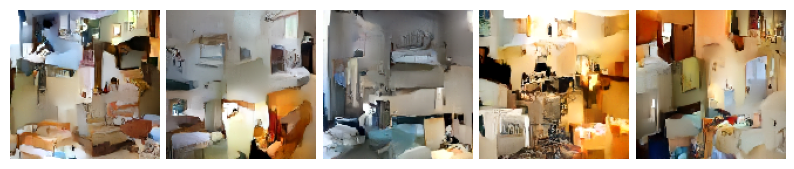

In [8]:
model.plot_images(model_i=1)

In [9]:
calculate_fid(model, image_size, train_dataset, batch_size)

50/50 [==============================] - 1s 15ms/step


10.318224444909632

#### 2.

In [10]:
## 250 epochs, 12800 samples, 128x128 images, 0.001 learning rate, 0.0001 weight decay

# hyper-parameters
image_size = 128

learning_rate = 1e-3
weight_decay = 1e-4

widths = [32, 64, 96, 128]
block_depth = 2

sample_size = 32 * 400
num_epochs = 250

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [11]:
# 'ddim_250_12800_0.001_0.0001.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}.weights.tf");

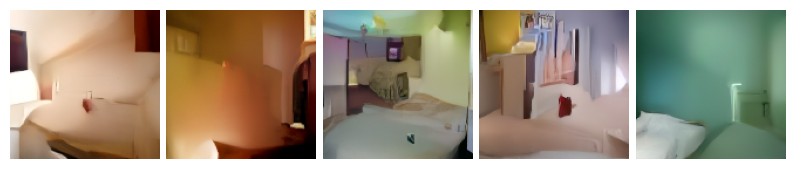

In [12]:
model.plot_images(model_i=2)

In [13]:
calculate_fid(model, image_size, train_dataset, batch_size)

300/300 [==============================] - 4s 15ms/step


10.451010217716192

#### 3.

In [14]:
## 200 epochs, 16000 samples, 128x128 images, 0.0005 learning rate, 0.00005 weight decay

# hyper-parameters
image_size = 128

learning_rate = 5e-4
weight_decay = 5e-5

widths = [32, 64, 96, 128]
block_depth = 2

sample_size = 32 * 500
num_epochs = 200

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [15]:
# 'ddim_200_16000_0.0005_5e-05.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}.weights.tf");

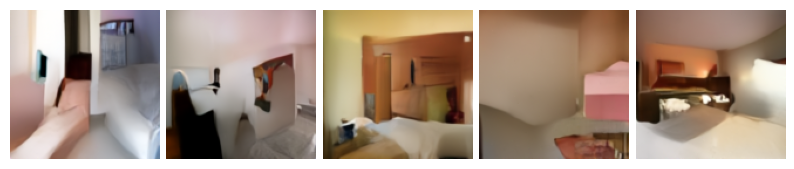

In [16]:
model.plot_images(model_i=3)

In [19]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 3s 15ms/step


18.333911219243696

#### 4.

In [20]:
## 300 epochs, 8000 samples, 80x80 images, 0.001 learning rate, 0.0001 weight decay

# hyper-parameters
image_size = 80

learning_rate = 1e-3
weight_decay = 1e-4

widths = [32, 64, 96, 128]
block_depth = 2

sample_size = 32 * 250
num_epochs = 300

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [21]:
# 'ddim_300_8000_0.001_0.0001_80.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}.weights.tf");

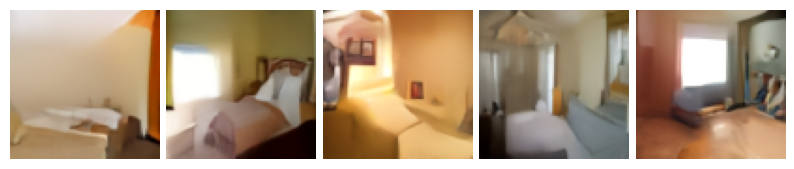

In [22]:
model.plot_images(model_i=4)

In [23]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 2s 10ms/step


9.753344016246244

#### 5.

In [24]:
## 200 epochs, 8000 samples + 8000 images augmented, 80x80 images, 0.001 learning rate, 0.0001 weight decay

# hyper-parameters
image_size = 80

learning_rate = 1e-3
weight_decay = 1e-4

widths = [32, 64, 96, 128]
block_depth = 2

sample_size = 32 * 250
num_epochs = 200

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)

train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [25]:
# 'ddim_200_8000_0.001_0.0001_80_augmented.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented.weights.tf");

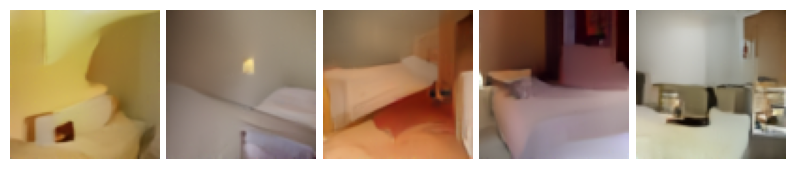

In [26]:
model.plot_images(model_i=5)

In [27]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 2s 10ms/step


9.7737588754162

#### 6.

In [28]:
## 400 epochs, 8000 samples + 8000 images augmented, 80x80 images, 0.0005 learning rate, 0.00005 weight decay

# hyper-parameters
image_size = 80

learning_rate = 5e-4
weight_decay = 5e-5

widths = [32, 64, 96, 128]
block_depth = 2

sample_size = 32 * 250
num_epochs = 400

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)

train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [29]:
# 'ddim_400_8000_0.0005_5e-05_80_augmented.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented.weights.tf");

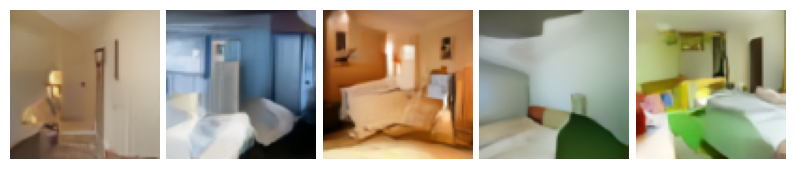

In [30]:
model.plot_images(model_i=6)

In [31]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 2s 10ms/step


7.939711895290845

#### 7.

In [32]:
## 300 epochs, 12000 samples + 12000 images augmented, 80x80 images, 0.0001 learning rate, 0.00001 weight decay, block depth = 3

# hyper-parameters
image_size = 80

learning_rate = 1e-4
weight_decay = 1e-5

widths = [32, 64, 96, 128]
block_depth = 3

sample_size = 32 * 375
num_epochs = 300

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)

train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [33]:
# 'ddim_300_12000_0.0001_1e-05_80_augmented_3blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_3blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_3blockdepth.weights.tf");

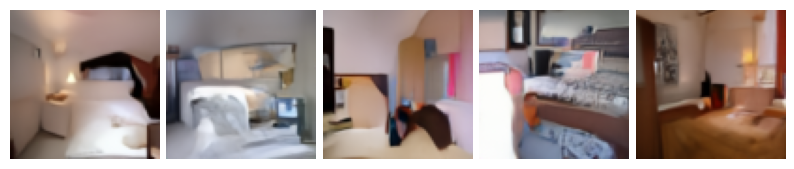

In [34]:
model.plot_images(model_i=7)

In [35]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 2s 10ms/step


5.729964753216837

#### 8.

In [36]:
## 300 epochs, 32000 samples, 80x80 images, 0.0001 learning rate, 0.00001 weight decay, block depth = 3

# hyper-parameters
image_size = 80

learning_rate = 1e-4
weight_decay = 1e-5

widths = [32, 64, 96, 128]
block_depth = 3

sample_size = 32 * 1000
num_epochs = 300

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [37]:
# 'ddim_300_32000_0.0001_1e-05_80_3blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_3blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_3blockdepth.weights.tf");

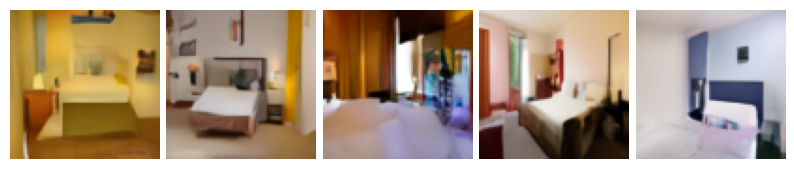

In [38]:
model.plot_images(model_i=8)

In [39]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 2s 11ms/step


5.72532631584588

#### 9.

In [40]:
## 300 epochs, 16000 samples + 16000 images augmented, 80x80 images, 0.00005 learning rate, 0.000005 weight decay, block depth = 4

# hyper-parameters
image_size = 80

learning_rate = 5e-5
weight_decay = 5e-6

widths = [32, 64, 96, 128]
block_depth = 4

sample_size = 32 * 500
num_epochs = 300

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)

train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [41]:
# 'ddim_300_16000_5e-05_5e-06_80_augmented_4blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf");

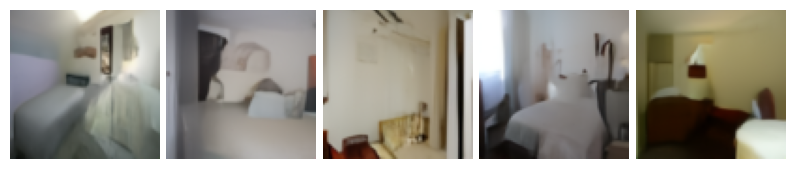

In [42]:
model.plot_images(model_i=9)

In [43]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 2s 10ms/step


5.004085279429746

#### 10.

In [68]:
# hyper-parameters
image_size = 112

learning_rate = 5e-4
weight_decay = 1e-5

widths = [32, 64, 96, 128, 256]
block_depth = 4

sample_size = 32 * 100
num_epochs = 400

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)
train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [69]:
# 'ddim_400_3200_0.0005_1e-05_112_augmented_4blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf");

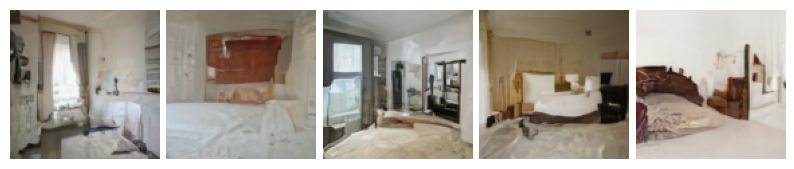

In [70]:
model.plot_images(model_i=10)

In [47]:
calculate_fid(model, image_size, train_dataset, batch_size)

200/200 [==============================] - 3s 13ms/step


42.72525721029365

#### 11.

In [48]:
# hyper-parameters
image_size = 112

learning_rate = 5e-4
weight_decay = 1e-5

widths = [32, 64, 96, 128, 256]
block_depth = 4

sample_size = 32 * 200
num_epochs = 400

batch_size = 16

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)
train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [49]:
# 'ddim_400_6400_0.0005_1e-05_112_augmented_4blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf");

In [50]:
calculate_fid(model, image_size, train_dataset, batch_size)

100/100 [==============================] - 1s 13ms/step


45.87642171862152

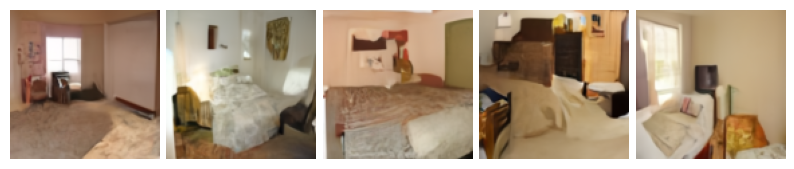

In [51]:
model.plot_images(model_i=11)

#### 12.

In [52]:
# hyper-parameters
image_size = 112

learning_rate = 5e-4
weight_decay = 1e-5

widths = [32, 64, 96, 128, 256]
block_depth = 4

sample_size = 32 * 400
num_epochs = 200

batch_size = 16

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)
train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [53]:
# 'ddim_200_12800_0.0005_1e-05_112_augmented_4blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf");

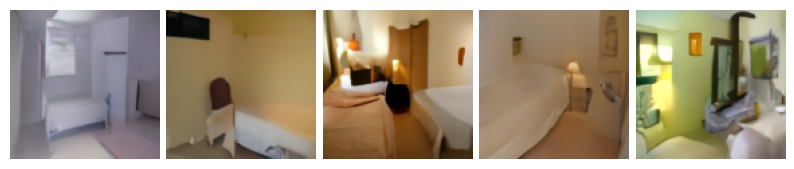

In [54]:
model.plot_images(model_i=12)

In [55]:
calculate_fid(model, image_size, train_dataset, batch_size)

100/100 [==============================] - 1s 13ms/step


56.458182824592996

#### 13.

In [60]:
# hyper-parameters
image_size = 112

learning_rate = 5e-4
weight_decay = 1e-5

widths = [32, 64, 96, 128, 256]
block_depth = 4

sample_size = 32 * 800
num_epochs = 200

batch_size = 16

# dataset
train_dataset = (
    DS.take(sample_size)
    .map(lambda img: preprocess_image(img, image_size=image_size))
    .cache()
)
flip_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal")
])
train_dataset_augmented = train_dataset.shuffle(sample_size).take(sample_size).map(lambda x: flip_augmentation(x), tf.data.AUTOTUNE)
train_dataset = train_dataset.concatenate(train_dataset)
train_dataset = (
    train_dataset
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [61]:
# 'ddim_200_25600_0.0005_1e-05_112_augmented_4blockdepth.weights.tf'

# model.fit(
#     train_dataset,
#     epochs=num_epochs,
# )
# model.save_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf")
model.load_weights(f"ddim_{num_epochs}_{sample_size}_{learning_rate}_{weight_decay}_{image_size}_augmented_4blockdepth.weights.tf");

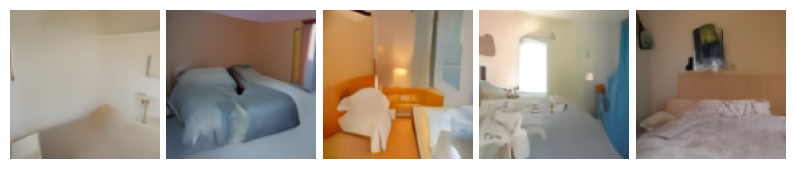

In [62]:
model.plot_images(model_i=13)

In [59]:
calculate_fid(model, image_size, train_dataset, batch_size)

100/100 [==============================] - 1s 13ms/step


64.97504542971417

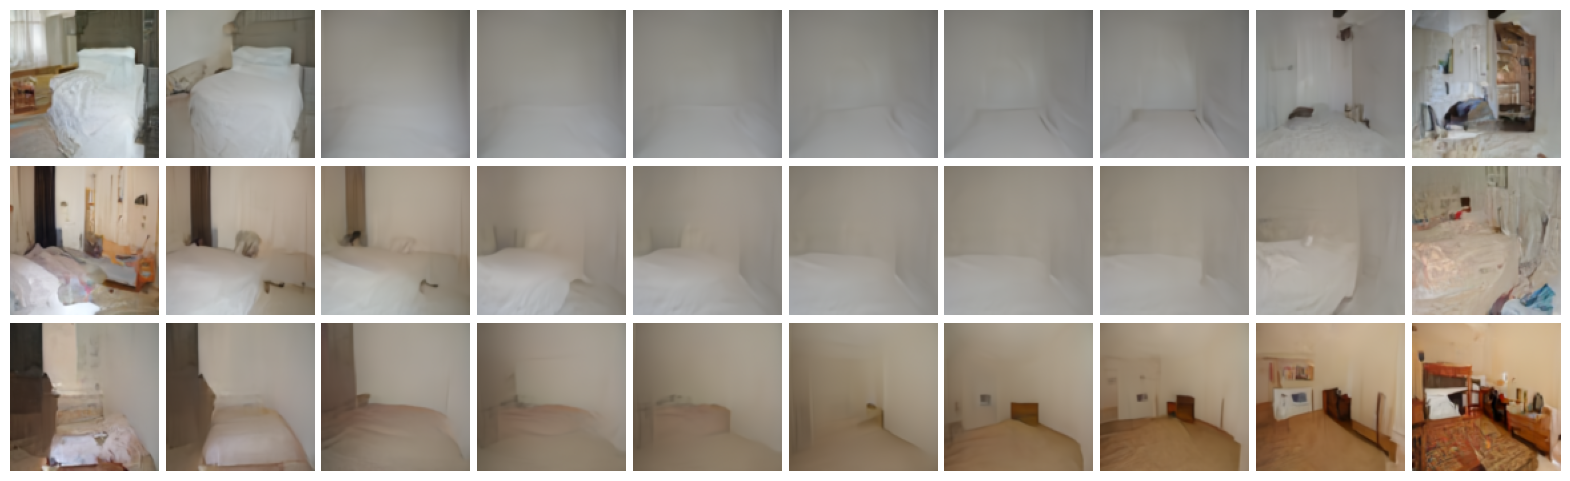

In [74]:
fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))

for i in range(3):
    latent_matrix1 = tf.random.normal(shape=(image_size, image_size, 3))
    latent_matrix2 = tf.random.normal(shape=(image_size, image_size, 3))

    interpolated_matrices = []
    for weight in tf.linspace(0.0, 1.0, 10):
        interpolated_matrix = latent_matrix1 * (1 - weight) + latent_matrix2 * weight
        interpolated_matrices.append(interpolated_matrix)

    interpolated_matrices = tf.stack(interpolated_matrices)

    generated_images = model.reverse_diffusion(interpolated_matrices, plot_diffusion_steps)
    generated_images = model.denormalize(generated_images)

    for j in range(10):
        axs[i, j].imshow(generated_images[j])
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()